<a href="https://colab.research.google.com/github/Mayank85Y/Elasticity/blob/main/Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm

Setting up neural net

In [2]:
# Set random seeds for reproducibility
np.random.seed(1234)
torch.manual_seed(1234)

class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64, 64, 64, 64]):
        super(NeuralNet, self).__init__()

        # Input layer
        layers = [nn.Linear(input_dim, hidden_layers[0]), nn.Tanh()]

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.Tanh())

        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Elasticity PINN

In [3]:
class ElasticityPINN:
    def __init__(self, domain_bounds, hidden_layers=[64, 64, 64, 64]):

        self.domain_bounds = domain_bounds
        self.x_min, self.x_max = domain_bounds[0]
        self.y_min, self.y_max = domain_bounds[1]

        # neural network
        self.net = NeuralNet(input_dim=2, output_dim=2, hidden_layers=hidden_layers)

        # Material properties
        self.E = 1.0  # Young's modulus (normalized)
        self.nu = 0.3  # Poisson's ratio

        # Lame parameters
        self.lambda_ = self.E * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
        self.mu = self.E / (2 * (1 + self.nu))

        # Optimizer
        self.optimizer = optim.Adam(self.net.parameters(), lr=0.001)

    def net_uv(self, x, y):

        xy = torch.cat([x, y], dim=1)
        uv = self.net(xy)

        u = uv[:, 0:1]
        v = uv[:, 1:2]

        return u, v

    def net_strain(self, x, y):

        x.requires_grad_(True)
        y.requires_grad_(True)

        u, v = self.net_uv(x, y)

        # Calculate gradients
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
        v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
        v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]

        # Strain components
        eps_xx = u_x
        eps_yy = v_y
        eps_xy = 0.5 * (u_y + v_x)

        return eps_xx, eps_yy, eps_xy

    def net_stress(self, x, y):

        eps_xx, eps_yy, eps_xy = self.net_strain(x, y)

        #Stress  using Hooke's law
        sigma_xx = 2 * self.mu * eps_xx + self.lambda_ * (eps_xx + eps_yy)
        sigma_yy = 2 * self.mu * eps_yy + self.lambda_ * (eps_xx + eps_yy)
        sigma_xy = 2 * self.mu * eps_xy

        return sigma_xx, sigma_yy, sigma_xy

    def pde_residual(self, x, y):

        x.requires_grad_(True)
        y.requires_grad_(True)

        sigma_xx, sigma_yy, sigma_xy = self.net_stress(x, y)

        # gradients for equilibrium equations
        sigma_xx_x = torch.autograd.grad(sigma_xx.sum(), x, create_graph=True)[0]
        sigma_xy_y = torch.autograd.grad(sigma_xy.sum(), y, create_graph=True)[0]
        sigma_xy_x = torch.autograd.grad(sigma_xy.sum(), x, create_graph=True)[0]
        sigma_yy_y = torch.autograd.grad(sigma_yy.sum(), y, create_graph=True)[0]

        # Residuals from equilibrium equations (assuming no body forces)
        r_x = sigma_xx_x + sigma_xy_y
        r_y = sigma_xy_x + sigma_yy_y

        return r_x, r_y

    def generate_training_data(self, n_domain=1000, n_boundary=200):

        # Domain points
        x_domain = torch.FloatTensor(np.random.uniform(self.x_min, self.x_max, n_domain)).reshape(-1, 1)
        y_domain = torch.FloatTensor(np.random.uniform(self.y_min, self.y_max, n_domain)).reshape(-1, 1)

        # Boundary points
        x_boundary_left = torch.FloatTensor(np.ones(n_boundary) * self.x_min).reshape(-1, 1)
        y_boundary_left = torch.FloatTensor(np.random.uniform(self.y_min, self.y_max, n_boundary)).reshape(-1, 1)

        x_boundary_right = torch.FloatTensor(np.ones(n_boundary) * self.x_max).reshape(-1, 1)
        y_boundary_right = torch.FloatTensor(np.random.uniform(self.y_min, self.y_max, n_boundary)).reshape(-1, 1)

        x_boundary_bottom = torch.FloatTensor(np.random.uniform(self.x_min, self.x_max, n_boundary)).reshape(-1, 1)
        y_boundary_bottom = torch.FloatTensor(np.ones(n_boundary) * self.y_min).reshape(-1, 1)

        x_boundary_top = torch.FloatTensor(np.random.uniform(self.x_min, self.x_max, n_boundary)).reshape(-1, 1)
        y_boundary_top = torch.FloatTensor(np.ones(n_boundary) * self.y_max).reshape(-1, 1)

        # Combine boundary points
        x_boundary = torch.cat([x_boundary_left, x_boundary_right, x_boundary_bottom, x_boundary_top])
        y_boundary = torch.cat([y_boundary_left, y_boundary_right, y_boundary_bottom, y_boundary_top])

        # Boundary condition values (example: fixed left edge, traction on right edge)
        bc_left = {'type': 'dirichlet', 'values': [0.0, 0.0]}  # Fixed (u=0, v=0)
        bc_right = {'type': 'neumann', 'values': [1.0, 0.0]}   # Traction in x-direction
        bc_bottom = {'type': 'dirichlet', 'values': [None, 0.0]}  # Free in x, fixed in y
        bc_top = {'type': 'neumann', 'values': [0.0, 0.0]}     # Free boundary

        boundary_conditions = {
            'left': {'coords': (x_boundary_left, y_boundary_left), 'bc': bc_left},
            'right': {'coords': (x_boundary_right, y_boundary_right), 'bc': bc_right},
            'bottom': {'coords': (x_boundary_bottom, y_boundary_bottom), 'bc': bc_bottom},
            'top': {'coords': (x_boundary_top, y_boundary_top), 'bc': bc_top}
        }

        return x_domain, y_domain, x_boundary, y_boundary, boundary_conditions

    def compute_boundary_loss(self, boundary_conditions):
        bc_loss = 0.0

        for boundary, data in boundary_conditions.items():
            x, y = data['coords']
            bc = data['bc']

            if bc['type'] == 'dirichlet':
                u, v = self.net_uv(x, y)
                u_bc, v_bc = bc['values']

                if u_bc is not None:
                    bc_loss += torch.mean((u - u_bc) ** 2)
                if v_bc is not None:
                    bc_loss += torch.mean((v - v_bc) ** 2)

            elif bc['type'] == 'neumann':
                sigma_xx, sigma_yy, sigma_xy = self.net_stress(x, y)
                tx_bc, ty_bc = bc['values']

                # Normal vectors based on boundary
                if boundary == 'left':
                    nx, ny = -1.0, 0.0
                elif boundary == 'right':
                    nx, ny = 1.0, 0.0
                elif boundary == 'bottom':
                    nx, ny = 0.0, -1.0
                elif boundary == 'top':
                    nx, ny = 0.0, 1.0

                # Calculate traction: t_i = sigma_ij * n_j
                tx = sigma_xx * nx + sigma_xy * ny
                ty = sigma_xy * nx + sigma_yy * ny

                bc_loss += torch.mean((tx - tx_bc) ** 2 + (ty - ty_bc) ** 2)

        return bc_loss

    def train(self, n_epochs=10000, print_every=500):

        x_domain, y_domain, x_boundary, y_boundary, boundary_conditions = self.generate_training_data()

        # Training loop
        for epoch in range(n_epochs):
            self.optimizer.zero_grad()

            # PDE residual loss
            r_x, r_y = self.pde_residual(x_domain, y_domain)
            pde_loss = torch.mean(r_x**2 + r_y**2)

            # Boundary condition loss
            bc_loss = self.compute_boundary_loss(boundary_conditions)

            # Total loss
            loss = pde_loss + bc_loss

            # Backpropagation and optimization
            loss.backward()
            self.optimizer.step()

            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}, PDE Loss: {pde_loss.item():.6f}, BC Loss: {bc_loss.item():.6f}")

    def predict(self, x, y):

        # Convert numpy to torch if needed
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x).reshape(-1, 1)
            y = torch.FloatTensor(y).reshape(-1, 1)

        # gradients during prediction for strains and stresses
        x.requires_grad_(True)
        y.requires_grad_(True)

        with torch.set_grad_enabled(True):  # Allow gradient computation during prediction
            u, v = self.net_uv(x, y)
            eps_xx, eps_yy, eps_xy = self.net_strain(x, y)
            sigma_xx, sigma_yy, sigma_xy = self.net_stress(x, y)

        # Detach tensors from computation graph for plotting
        u = u.detach()
        v = v.detach()
        eps_xx = eps_xx.detach()
        eps_yy = eps_yy.detach()
        eps_xy = eps_xy.detach()
        sigma_xx = sigma_xx.detach()
        sigma_yy = sigma_yy.detach()
        sigma_xy = sigma_xy.detach()

        return u, v, eps_xx, eps_yy, eps_xy, sigma_xx, sigma_yy, sigma_xy

    def plot_results(self, resolution=50):

        # Create grid for plotting
        x = np.linspace(self.x_min, self.x_max, resolution)
        y = np.linspace(self.y_min, self.y_max, resolution)
        X, Y = np.meshgrid(x, y)

        # Convert to torch tensors
        x_flat = torch.FloatTensor(X.flatten()).reshape(-1, 1)
        y_flat = torch.FloatTensor(Y.flatten()).reshape(-1, 1)

        # Predict values
        u, v, eps_xx, eps_yy, eps_xy, sigma_xx, sigma_yy, sigma_xy = self.predict(x_flat, y_flat)

        # Convert to numpy for plotting
        u = u.numpy().reshape(X.shape)
        v = v.numpy().reshape(X.shape)
        sigma_xx = sigma_xx.numpy().reshape(X.shape)
        sigma_yy = sigma_yy.numpy().reshape(X.shape)
        sigma_xy = sigma_xy.numpy().reshape(X.shape)

        # Plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Displacements
        im0 = axes[0, 0].contourf(X, Y, u, 50, cmap=cm.jet)
        axes[0, 0].set_title('Displacement u')
        axes[0, 0].set_xlabel('x')
        axes[0, 0].set_ylabel('y')
        plt.colorbar(im0, ax=axes[0, 0])

        im1 = axes[0, 1].contourf(X, Y, v, 50, cmap=cm.jet)
        axes[0, 1].set_title('Displacement v')
        axes[0, 1].set_xlabel('x')
        axes[0, 1].set_ylabel('y')
        plt.colorbar(im1, ax=axes[0, 1])

        # Displacement magnitude
        disp_mag = np.sqrt(u**2 + v**2)
        im2 = axes[0, 2].contourf(X, Y, disp_mag, 50, cmap=cm.jet)
        axes[0, 2].set_title('Displacement Magnitude')
        axes[0, 2].set_xlabel('x')
        axes[0, 2].set_ylabel('y')
        plt.colorbar(im2, ax=axes[0, 2])

        # Stress
        im3 = axes[1, 0].contourf(X, Y, sigma_xx, 50, cmap=cm.jet)
        axes[1, 0].set_title('Stress σxx')
        axes[1, 0].set_xlabel('x')
        axes[1, 0].set_ylabel('y')
        plt.colorbar(im3, ax=axes[1, 0])

        im4 = axes[1, 1].contourf(X, Y, sigma_yy, 50, cmap=cm.jet)
        axes[1, 1].set_title('Stress σyy')
        axes[1, 1].set_xlabel('x')
        axes[1, 1].set_ylabel('y')
        plt.colorbar(im4, ax=axes[1, 1])

        im5 = axes[1, 2].contourf(X, Y, sigma_xy, 50, cmap=cm.jet)
        axes[1, 2].set_title('Stress σxy')
        axes[1, 2].set_xlabel('x')
        axes[1, 2].set_ylabel('y')
        plt.colorbar(im5, ax=axes[1, 2])

        plt.tight_layout()
        plt.show()

Results

Epoch 0, Loss: 0.833530, PDE Loss: 0.001574, BC Loss: 0.831956
Epoch 500, Loss: 0.007142, PDE Loss: 0.001031, BC Loss: 0.006110
Epoch 1000, Loss: 0.003929, PDE Loss: 0.000358, BC Loss: 0.003571
Epoch 1500, Loss: 0.002774, PDE Loss: 0.000285, BC Loss: 0.002489
Epoch 2000, Loss: 0.002743, PDE Loss: 0.000510, BC Loss: 0.002232
Epoch 2500, Loss: 0.002044, PDE Loss: 0.000195, BC Loss: 0.001848
Epoch 3000, Loss: 0.001851, PDE Loss: 0.000178, BC Loss: 0.001673
Epoch 3500, Loss: 0.001660, PDE Loss: 0.000170, BC Loss: 0.001490
Epoch 4000, Loss: 0.001517, PDE Loss: 0.000165, BC Loss: 0.001352
Epoch 4500, Loss: 0.001332, PDE Loss: 0.000129, BC Loss: 0.001203


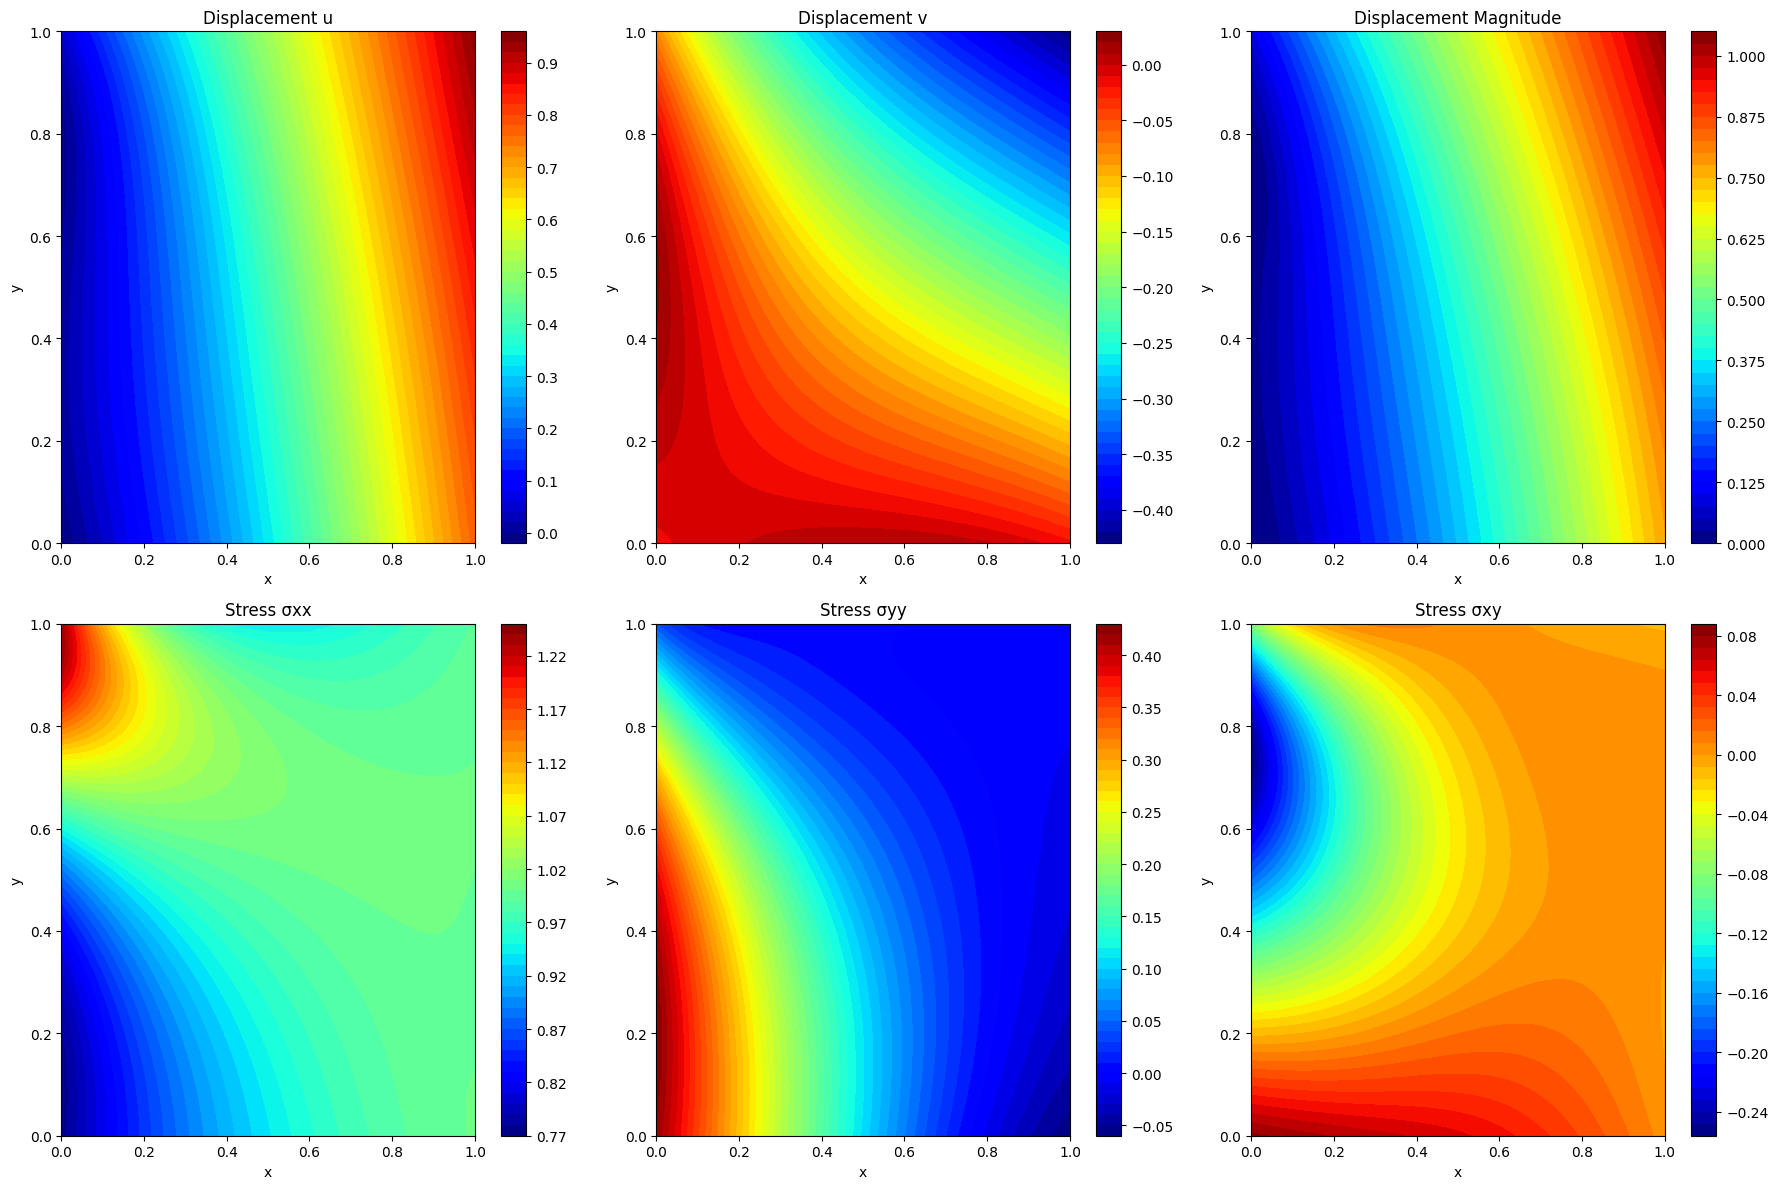

In [4]:

if __name__ == "__main__":
    #domain bounds
    domain_bounds = [(0.0, 1.0), (0.0, 1.0)]  # Unit square domain

    # Create the PINN model
    pinn = ElasticityPINN(domain_bounds, hidden_layers=[64, 64, 64, 64])

    # Train the model
    pinn.train(n_epochs=5000, print_every=500)

    # Plot results
    pinn.plot_results()